# TRABAJO Parte 2: AIA_2022-2023

# Transfer Learning con CNNs - Dataset: Flowers

La idea de este trabajo es familiarizarnos con dos situaciones muy habituales en la actividad real de un "Machine Learning Engineer":

1.   En primer lugar, con una de las técnicas más potentes asociadas con las redes neuronales: el **Transfer Learning**. Dado que las redes neuronales, para resolver un problema, capturan en su estructura de capas y pesos una representación jerárquica del problema.
Entonces..., ¿por qué no aprovechar ese conocimiento obtenido, para resolver otro problema diferente?

2.  En segundo lugar, con la **busqueda de información sobre conceptos nuevos**. En este caso, los dos primeros modelos a implementar los hemos trabajado en clase. No así el Transfer Learning, y por tanto, deberéis buscar vosotros mismos cómo hacer lo que se pide para el Modelo 3. Consultar en blogs, web y tutoriales es algo común en el día a día de alguien que quiere profundizar en el ML y, para ello, existen infinidad de fuentes. A modo de ejemplo, una fuente para profundizar en el Transfer Learning con redes convolucionales es: https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

En este trabajo vamos intentar resolver un problema de clasificación sobre un dataset propuesto por Tensorflow en 2019 conocido como "flowers". Este conjunto está formado por 3670 imágenes de flores pertenecientes a 5 clases diferentes. Para ello implementaremos 3 modelos:

*   Modelo 1: implementación de una CNN básica.
*   Modelo 2: es una evolución del modelo anterior, aplicando técnicas que reduzcan el overfitting.
*   Modelo 3: rompemos la barrera de tener que seguir complicando nuestro modelo y se pide aplicar transfer learning utilizando un pre-trained model.





# a) Carga de datos

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import pathlib
import os
import glob
import shutil
tf.__version__

'2.13.0'

Descargamos el dataset que pone a nuestra disposición Tensorflow.

In [2]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228813984/228813984 [==============================] - 10s 0us/step


Tras completar la descarga, debemos tener la siguiente estructura de directorios:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

Desgraciadamente, para este dataset, Tensorflow no nos proporciona la estructura de directorios necesaria de train y de validación. Por lo que debemos proceder del siguiente modo:

* Crear una carpeta `train` y de `val`, cada una de ellas debe contener a su vez, cinco subdirectorios: uno para cada clase de flor.
* Moveremos las imágenes de las carpetas originales a estas nuevas carpetas. De modo que el 80% de las imágenes vayan al conjunto de train y el 20% restante al de validación.
* La estructura final de directorios debe ser la siguiente:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [12.jpg, 28.jpg, 31.jpg ....]
    |______ <b>dandelion</b>: [41.jpg, 22.jpg, 35.jpg ....]
    |______ <b>roses</b>: [121.jpg, 92.jpg, 38.jpg ....]
    |______ <b>sunflowers</b>: [93.jpg, 23.jpg, 83.jpg ....]
    |______ <b>tulips</b>: [109.jpg, 267.jpg, 93.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>

Creamos una lista con el nombre de las 5 clases. En castellano sería: margaritas, diente de león, rosas, girasoles y tulipanes.

In [3]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

Creemos la estructura de directorios necesaria:

In [4]:
SPLIT_RATIO=0.8

for cl in classes:
    # path de las imagenes de la clase cl
    img_path = os.path.join(base_dir, cl)

    # obtenemos la lista de todas las imagenes
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Imagenes".format(cl, len(images)))

    # determinamos cuantas imagenes son el 80%
    num_train = int(round(len(images)*SPLIT_RATIO))

    # separamos las imagenes en dos listas
    train, val = images[:num_train], images[num_train:]

    # creamos la carpeta de train/clase y val/clase
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))

    # movemos las imagenes
    for t in train:
        shutil.move(t, os.path.join(base_dir, 'train', cl))
    for v in val:
        shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Imagenes
daisy: 633 Imagenes
dandelion: 898 Imagenes
sunflowers: 699 Imagenes
tulips: 799 Imagenes


Preparamos variables con las rutas de los diferentes directorios:

In [5]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

daisy_dir = os.path.join(train_dir, 'daisy')
dandelion_dir = os.path.join(train_dir, 'dandelion')
roses_dir = os.path.join(train_dir, 'roses')
sunflowers_dir = os.path.join(train_dir, 'sunflowers')
tulips_dir = os.path.join(train_dir, 'tulips')

Muestre el nombre de dos ficheros cualquiera en alguna de esas rutas:

In [6]:
# Obtenemos todos los ficheros contenidos en la ruta daisy_dir
ficheros = os.listdir(daisy_dir)

# Imprimimos el nombre de los dos primeros ficheros
print(ficheros[:2])

['10466290366_cc72e33532.jpg', '2536529152_33ef3ee078_n.jpg']


Es decir, la clase a la que pertenece cada imagen no viene dada por el nombre del fichero sino por el directorio en el que se encuentra almacenada.

Muestra el número de imágenes de train que tenemos de cada clase:

In [7]:
num_daisy = len(os.listdir(daisy_dir))
num_dandelion = len(os.listdir(dandelion_dir))
num_roses = len(os.listdir(roses_dir))
num_sunflowers = len(os.listdir(sunflowers_dir))
num_tulips = len(os.listdir(tulips_dir))

print(f"Número de margaritas: {num_daisy}")
print(f"Número de dientes de león: {num_dandelion}")
print(f"Número de rosas: {num_roses}")
print(f"Número de girasoles: {num_sunflowers}")
print(f"Número de tulipanes: {num_tulips}")

Número de margaritas: 506
Número de dientes de león: 718
Número de rosas: 513
Número de girasoles: 559
Número de tulipanes: 639


# b) Visualización del dataset

Muestra 3 imágenes de cada una de las clases, utilizando como título de la imagen, el shape del array de numpy asociado a cada imagen. Comprueba que las imágenes tienen diferentes shapes, por lo que más adelante tendremos que unificar su tamaño.

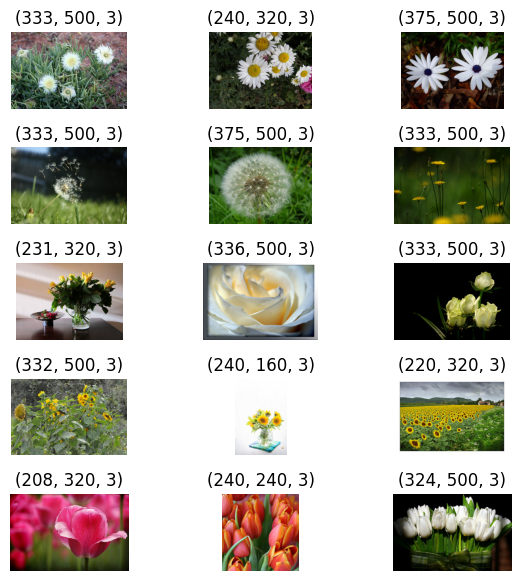

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Creamos el grid para las imágenes con 5 filas y 3 columnas
fig, ax = plt.subplots(5, 3, figsize=(7,7))
axes = ax.ravel()

# Obtenemos las rutas de las 3 primeras imágenes de cada clase
img_daisy = [os.path.join(daisy_dir, img) for img in os.listdir(daisy_dir)[:3]]
img_dandelion = [os.path.join(dandelion_dir, img) for img in os.listdir(dandelion_dir)[:3]]
img_roses = [os.path.join(roses_dir, img) for img in os.listdir(roses_dir)[:3]]
img_sunflowers = [os.path.join(sunflowers_dir, img) for img in os.listdir(sunflowers_dir)[:3]]
img_tulips = [os.path.join(tulips_dir, img) for img in os.listdir(tulips_dir)[:3]]

for i, ruta_img in enumerate(img_daisy + img_dandelion + img_roses + img_sunflowers + img_tulips):
    img = mpimg.imread(ruta_img)        # Obtenemos la imagen dada la ruta
    axes[i].imshow(img)                 # Mostramos la imagen en la casilla indicada
    axes[i].axis('off')                 # Quitamos los ejes
    axes[i].set_title(f"{img.shape}")   # Le ponemos como titulo el shape de la imagen

# Añadimos un espacio vertical entre casillas para que se vea bien
plt.subplots_adjust(hspace=0.5)

# c) Modelo 1: CNN básica (objetivo: accuracy_valid > 60%)


Implemente una red convolucional para resolver el problema de clasificación. Para ello se sugiere una CNN con 3 capas convolucionales + pooling con la siguiente estructura:

Bloque de procesamiento de imagen:
1.   32 kernels -> 64 kernels -> 96 kernels
2.   kernels de 3x3.
3.   Stride = 1 y padding = SI.
4.   Función de activación ReLU.
5.   Maxpooling de 2x2 con stride clásico de 2 pixeles.
6.   Igualamos el tamaño de todas las imágenes a 150 x 150.

Bloque de decisión:
7.   Capa densa de 512 neuronas.
8.   Capa densa de salida.

**Entrene un modelo con la estructura anterior de manera que obtenga un accuracy (sobre el conjunto de validación) > 60%.** Utilice el optimizador que considere más adecuado.

Sugerencias:
*   Recuerda que si no se realiza conversión a One-Hot de la etiqueta a predecir, debes utilizar como función de error `SparseCategoricalCrossentropy` (este es el procedimiento que hemos usado en clase).
*   Considera un learning rate en el entorno de 0.001.
*   En el caso de los generators utiliza `class_mode='sparse'`.
*   Puedes utilizar p.e. un `batch_size = 100`.




In [9]:
model = keras.Sequential()

# Entrada: (150,150,3)
model.add(keras.layers.Conv2D(
    filters = 32,
    kernel_size = (3,3),
    strides = (1,1),
    padding = 'same',
    activation = 'relu',
    input_shape = (150,150,3),
    name = 'Conv_1'
))

# Entrada: (150,150,32)
model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, name='Pool_1'))

# Entrada: (75,75,32)
model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1),
                              padding = 'same', activation = 'relu',
                              name = 'Conv_2'))

# Entrada: (75,75,64)
model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, name='Pool_2'))

# Entrada: (37,37,64)
model.add(keras.layers.Conv2D(filters = 96, kernel_size = (3,3), strides = (1,1),
                              padding = 'same', activation = 'relu',
                              name = 'Conv_3'))

# Entrada: (37,37,96)
model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, name='Pool_3'))

# Entrada: (18,18,96)
model.add(keras.layers.Flatten(name='flatten'))

# Entrada: (31104)
model.add(keras.layers.Dense(units=512, activation='relu', name='densa_1'))

# Entrada: (512)
model.add(keras.layers.Dense(units=5, activation='softmax'))

optimizador = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = optimizador,
              metrics=['acc'])

In [10]:
from keras.preprocessing.image import ImageDataGenerator

# Creamos generadores de imágenes para entrenamiento y validación
# el cual reescala las imágenes
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Cargamos las imágenes para conjunto de entrenamiento
train_generator1 = train_datagen.flow_from_directory(
    train_dir,                  # Directorio tomado
    target_size = (150,150),    # Tamaño al que se redimensionaran las imágenes
    batch_size = 100,           # Tamaño de los lotes
    class_mode = 'sparse'       # Clasificación multiclase
)

# Cargamos las imágenes para conjunto de validación
validation_generator1 = val_datagen.flow_from_directory(
    val_dir,
    target_size = (150,150),
    batch_size = 100,
    class_mode = 'sparse'
)

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


Indica cual es el shape de la imagen antes y después de cada capa de la red. **Explica cómo has obtenido dichos valores**. Compara el resultado con un summary() del modelo

|Capa| Shape a la salida| #parámetros |
|:-|:-:|:-:|
|Conv_1|(150,150,32)|896
|Pool_1|(75,75,32)|0
|Conv_2|(75,75,64)|18.496
|Pool_2|(37,37,64)|0
|flatten|(31104)|0
|densa_1|(512)|15.925.760

Explicación shape a la salida:
- **Conv_1**: No se modifica el ancho y el alto de la imagen porque añadimos padding y las imágenes tendrán 32 canales, ya que cada canal es el resultado de la aplicación de cada kernel, donde cada kernel produce un canal.
- **Pool_1**: Se divide a la mitad el ancho y el alto, ya que el tamaño del kernel es (2,2) y el stride 2. No se modifica el número de canales, ya que se hace pooling a cada canal y no se suman los resultados.
- **Conv_2**: No se modifica el ancho y el alto de la imagen porque añadimos padding y las imágenes tendrán 64 canales, ya que cada canal es el resultado de la aplicación de cada kernel, donde cada kernel produce un canal.
- **Pool_2**: Se divide a la mitad el ancho y el alto, ya que el tamaño del kernel es (2,2) y el stride 2. No se modifica el número de canales, ya que se hace pooling a cada canal y no se suman los resultados.
- **Flatten**: 18 píxeles de ancho x 18 píxeles de alto x 96 canales (resultados producidos por la capa anterior, *Pool3*) = 31104
- **Densa_1**: Devuelve un valor por cada neurona, por tanto, como la capa tiene 512 neuronas, pues devuelve 512 valores.

Explicación parámetros:
- **Conv_1**: Número de kernels (32) x Tamaño del kernel (3,3) x Número de canales de la imagen de entrada (3) + Número de kernels (32) = 32 x 3 x 3 x 3 + 32 = 896
- **Pool_1**: No tiene parámetros
- **Conv_2**: Número de kernels (64) x Tamaño del kernel (3,3) x Número de canales de la imagen de entrada (32) + Número de kernels (64) = 64 x 3 x 3 x 32 + 64 = 18.496
- **Pool_2**: No tiene parámetros
- **Flatten**: No tiene parámetros
- **Densa_1**: Le entran 31.104 valores y cada uno está conectado con cada neurona, es decir, cada uno tiene un peso asociado a cada neurona, más el término independiente de cada neurona. Por tanto, 31.104 x 512 + 512 = 15.925.760


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 Pool_1 (MaxPooling2D)       (None, 75, 75, 32)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 75, 75, 64)        18496     
                                                                 
 Pool_2 (MaxPooling2D)       (None, 37, 37, 64)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 37, 37, 96)        55392     
                                                                 
 Pool_3 (MaxPooling2D)       (None, 18, 18, 96)        0         
                                                                 
 flatten (Flatten)           (None, 31104)             0

Muestra la evolución de la función de error (train y valid) durante el entrenamiento.__Explica qué problema presenta el modelo que hemos entrenado.__

In [12]:
history1 = model.fit(
    train_generator1,
    steps_per_epoch = 29, # 2935 imágenes = batch_size (100) * steps
    epochs = 20,
    validation_data = validation_generator1,
    validation_steps = 7, # 735 imágenes = batch_size (100) * steps
    verbose=2,
)

Epoch 1/20
29/29 - 20s - loss: 1.6279 - acc: 0.3330 - val_loss: 1.1910 - val_acc: 0.5257 - 20s/epoch - 681ms/step
Epoch 2/20
29/29 - 8s - loss: 1.0833 - acc: 0.5686 - val_loss: 1.0485 - val_acc: 0.6071 - 8s/epoch - 270ms/step
Epoch 3/20
29/29 - 9s - loss: 0.9487 - acc: 0.6310 - val_loss: 0.9962 - val_acc: 0.6243 - 9s/epoch - 298ms/step
Epoch 4/20
29/29 - 8s - loss: 0.7829 - acc: 0.6959 - val_loss: 0.9834 - val_acc: 0.6357 - 8s/epoch - 290ms/step
Epoch 5/20
29/29 - 8s - loss: 0.6501 - acc: 0.7580 - val_loss: 0.9830 - val_acc: 0.6414 - 8s/epoch - 271ms/step
Epoch 6/20
29/29 - 9s - loss: 0.4870 - acc: 0.8162 - val_loss: 1.2123 - val_acc: 0.5700 - 9s/epoch - 307ms/step
Epoch 7/20
29/29 - 8s - loss: 0.3462 - acc: 0.8829 - val_loss: 1.2211 - val_acc: 0.6229 - 8s/epoch - 269ms/step
Epoch 8/20
29/29 - 7s - loss: 0.2475 - acc: 0.9164 - val_loss: 1.3963 - val_acc: 0.6286 - 7s/epoch - 251ms/step
Epoch 9/20
29/29 - 9s - loss: 0.1457 - acc: 0.9591 - val_loss: 1.7116 - val_acc: 0.6229 - 9s/epoch - 3

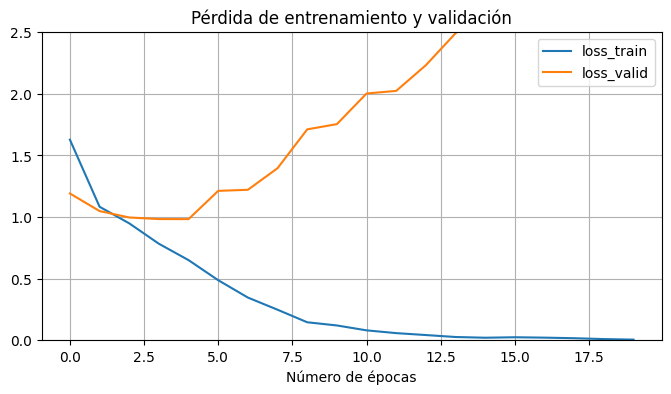

In [13]:
pd.DataFrame({'loss_train': history1.history['loss'],
              'loss_valid': history1.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,2.5)
plt.xlabel('Número de épocas')
plt.title('Pérdida de entrenamiento y validación');

Como se puede apreciar en la gráfica, el modelo presenta sobreajuste, ya que conforme van pasando las épocas, la pérdida en el conjunto de entrenamiento va disminuyendo, es decir, mejorando, mientras que en el conjunto de validación la pérdida no mejora. Por tanto, podemos concluir que el modelo está demasiado ajustando a los datos de entrenamiento, y no está generalizando.



# d) Modelo 2: reducción del overfitting (objetivo: accuracy_valid > 70%)

Introduzca en el modelo anterior las dos técnicas más habituales de reducción del overfitting:

    * drop-out
    * data augmentation

El objetivo es alcanzar un **objetivo es conseguir un accuracy sobre el conjunto de validacion > 70%.**

**Explica en qué consisten y qué utilidad tienen para nuestro problema**

El drop-out es una técnica que consiste en "apagar" neuronas de la capa a la que le apliquemos el drop-out, de forma que cada neurona de dicha capa tiene una probabilidad de que durante un mini-batch no se actualice su peso.

El data augmentation consiste en la creación de nuevos datos, en este caso imágenes, a partir del conjunto de entrenamiento, mediante ligeras modificaciones para que las imágenes creadas artificialmente no se distingan de las originales. De esta forma, aumentamos el conjunto de entrenamiento, y dificultamos al modelo el memorizar los datos.

__Explica qué tipos de augmentation vas a considerar y qué utilidad tienen en nuestro problema de clasificacion__

    * Flip horizontal: Simulamos la variación en el ángulo en el que se tomó la imagen.
    * Aumento y reduciendo de brillo: Simulamos variaciones en la condición en la que se realizó la imagen.
    * Zoom: Simulamos el acercamiento de la flor en la imagen.
    * Desplazamientos: Simulamos cambios en la posición de la flor en la imagen.
    * Rotación: Simulamos variaciones en la orientación de las flores.

In [14]:
# Generador de las imágenes de entrenamiento encargado de reescalar las imágenes
# y de crear nuevas mediante las técnicas de data augmentation mencionadas
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    brightness_range = (0.8, 1.2),
    zoom_range=0.25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    rotation_range=30,
 )

# Cargamos las imágenes
train_generator2 = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 100,
    class_mode = 'sparse'
)

Found 2935 images belonging to 5 classes.


Muestra la evolucion de la funcion de error durante el entrenamiento. __Explica qué diferencias de comportamiento hay entre las gráficas del modelo a) y las del modelo b)__

In [15]:
model2 = keras.Sequential()

model2.add(keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1),
                              padding = 'same', activation = 'relu',
                              input_shape = (150,150,3), name = 'Conv_1'))
model2.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, name='Pool_1'))
model2.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1),
                              padding = 'same', activation = 'relu',
                              name = 'Conv_2'))
model2.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, name='Pool_2'))
model2.add(keras.layers.Conv2D(filters = 96, kernel_size = (3,3), strides = (1,1),
                              padding = 'same', activation = 'relu',
                              name = 'Conv_3'))
model2.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, name='Pool_3'))
model2.add(keras.layers.Flatten(name='flatten'))
model2.add(keras.layers.Dense(units=512, activation='relu', name='densa_1'))
model2.add(keras.layers.Dropout(0.5))       # Drop-out
model2.add(keras.layers.Dense(units=5, activation='softmax'))

optimizador = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = optimizador,
              metrics=['acc'])

In [16]:
history2 = model2.fit(
    train_generator2,
    steps_per_epoch = 29, # 2935 imágenes = batch_size (100) * steps
    epochs = 20,
    validation_data = validation_generator1,   # El generator de validación es el mismo que en el modelo anterior
    validation_steps = 7, # 735 imágenes = batch_size (100) * steps
    verbose=2,
)

Epoch 1/20
29/29 - 26s - loss: 1.8302 - acc: 0.2889 - val_loss: 1.3455 - val_acc: 0.4000 - 26s/epoch - 897ms/step
Epoch 2/20
29/29 - 23s - loss: 1.2510 - acc: 0.4427 - val_loss: 1.2115 - val_acc: 0.4743 - 23s/epoch - 805ms/step
Epoch 3/20
29/29 - 24s - loss: 1.2062 - acc: 0.4857 - val_loss: 1.1448 - val_acc: 0.5557 - 24s/epoch - 814ms/step
Epoch 4/20
29/29 - 23s - loss: 1.1328 - acc: 0.5280 - val_loss: 1.1044 - val_acc: 0.5414 - 23s/epoch - 801ms/step
Epoch 5/20
29/29 - 24s - loss: 1.0677 - acc: 0.5633 - val_loss: 1.0527 - val_acc: 0.5786 - 24s/epoch - 823ms/step
Epoch 6/20
29/29 - 24s - loss: 1.0302 - acc: 0.5877 - val_loss: 1.0106 - val_acc: 0.5786 - 24s/epoch - 831ms/step
Epoch 7/20
29/29 - 24s - loss: 1.0199 - acc: 0.6025 - val_loss: 0.9781 - val_acc: 0.6200 - 24s/epoch - 823ms/step
Epoch 8/20
29/29 - 24s - loss: 0.9721 - acc: 0.6155 - val_loss: 0.9273 - val_acc: 0.6286 - 24s/epoch - 837ms/step
Epoch 9/20
29/29 - 24s - loss: 0.9470 - acc: 0.6148 - val_loss: 0.9402 - val_acc: 0.6243

Text(0.5, 1.0, 'Pérdida de validación entre modelo A y B')

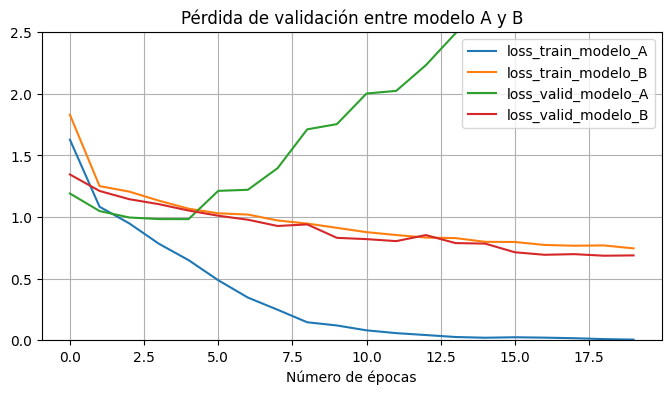

In [17]:
pd.DataFrame({'loss_train_modelo_A': history1.history['loss'],
              'loss_train_modelo_B': history2.history['loss'],
              'loss_valid_modelo_A': history1.history['val_loss'],
              'loss_valid_modelo_B': history2.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,2.5)
plt.xlabel('Número de épocas')
plt.title('Pérdida de validación entre modelo A y B')

En el modelo A, la pérdida en el conjunto de entrenamiento es menor que en el modelo B porque hay menos datos y los ha 'memorizado'. Sin embargo, la pérdida en el conjunto de validación es menor para el modelo B, por tanto, el modelo B es mejor que el modelo A. Además, se puede ver como en cada época la pérdida en el conjunto de validación va disminuyendo, y está muy a la par con el conjunto de validación, de forma que el modelo está aprendiendo correctamente.

# c) Modelo 3: Transfer Learning (objetivo: accuracy_valid > 88%)

En nuestro problema de clasificación de flores, el utilizar CNNs diseñadas y entrenadas por nosotros mismos, aparece una barrera en las proximidades del 75-80% de precisión del modelo (siempre sobre validación).

Para superar este escollo, el siguiente paso natural es la utilización de modelos preentrenados. Existe una gran variedad de ellos basados en redes CNNs clásicas, donde la principal diferencia es que acumulan más capas que nuestros modelos 1 y 2. Adicionalmente, en estos modelos se han ido incorporando diferentes propuestas para mejorar la arquitectura de la CNN.

En general, utilizando estos modelos convolucionales preentrenados podemos alcanzar accuracies próximos al 90%. Normalmente, estos modelos han sido previamente entrenados sobre datasets de gran tamaño y con gran número de categorías. P.e. en subconjuntos de Imagenet (14 millones de imagenes de 22K categorías).

Dado que estos modelos se entrenaron para resolver un problema "relativamente" parecido a nuestro problema de clasificación, parece razonable pensar que podemos aprovechar ese conocimiento capturado en la red para resolver nuestro problema de clasificación de flores.

Se pide que implemente y entrene un modelo utilizando una de estas redes pre-entrenadas (__con el objetivo de alcanzar un accuracy (sobre el conjunto de validación > 88%__). Los pasos que debe seguir son:

1.   Importa el modelo desde Tensorflow.
2.   Dado que este modelo ha sido entrenado para clasificar entre 1.000 categorías, las capas densas finales del modelo no son útiles para nuestro problema de clasificación de 5 categorías (es lo que suele llamarse include_top = SI/NO). De manera que eliminamos lo que a veces se suele llamar el "top model". De este modo sólo nos quedamos con la parte que hace la funcionalidad de "procesamiento" de la imagen.
3.   Añadimos una capa de flatten y tres nuevas capas densas especificas para nuestro problema con dimensiones 4096, 1072 y la que necesite la capa de salida (con sus correspondientes drop-out).
4.   Después haremos el denominado `Fine-Tuning` del modelo. Para ello le indicaremos a Tensorflow que únicamente debe entrenar:
   * Las dos últimas capas convolucinoales de la red preentrenada
   * Las tres capas densas que hemos incluido nuevas.

  De esta forma, quedan congeladas (no se entrenan los pesos) todas las capas convolucionales de la red preentrenada, excepto las dos últimas. Para estados dos últimas capas convolucionales, usando como punto de partida los del pre-trained model obtendremos un ajuste fino de sus pesos. Por supuesto, tensorflow entrenará no solo estas dos ultimas capas convolucionales, sino también las tres capas densas que hemos añadido.

5. Dado que estamos reutilizando un modelo que no "es nuestro", deberemos ceñirnos al tamaño de imagen que permite la red a la entrada.

Para elegir el modelo preentrenado que debe utilizar cada grupo, proceda del siguiente modo:
* Paso 1: sume los DNIs de los componentes del grupo (si el grupo tiene un sólo miembro, vaya directamente al paso 2). res = dni_1 + dn_2
* Paso 2: Aplique la siguiente operación al resultado anterior: res mod 6.
* Paso 3: Tome el modelo cuyo número asociado coincide con el resultado de la operación anterior.
* Paso 4: El porcentaje que aparece entre paréntesis junto al nombre del modelo es el accuracy (en validación) que deberías poder alcanzar sin dificultad utilizando el modelo. En todos los casos considera un input_shape = (224, 224, 3).

  0. Resnet50 (>90%)
  https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

  1. Resnet101 (>90%) input_shape = (224, 224, 3)
  https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet101

  2. VGG16 (>90%) input_shape = (224, 224, 3)
  https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

  3. VGG19 (>90%) input_shape = (224, 224, 3) https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19/VGG19

  4. Xception (>88%) input_shape = (224, 224, 3) https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception

  5. Inceptionv3 (>88%) input_shape = (224, 224, 3) https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3

P.e. si los DNIs de los alumnos son: 12345678 y 23456781. La suma es 35802467. De donde 35802467 mod 6 = 5. Por tanto, tomaríamos el modelo Inceptionv3.

In [18]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 5s 0us/step




6.   Una vez definido el modelo tenemos que crear los data_generators asociados. Para ello:
> * Utiliza Data augmentation.
> * Las imágenes tienen que ser preprocesadas igual que cuando se entrenó el modelo VGG original. Para ello se utiliza el parámetro `preprocessing_function=preprocess_input` (preprocess_input importado desde `keras.applications.vgg16` en ambos generators (train y valid). Por tanto, no hay que indicarle `rescale`. En caso de ser necesario, se encargará `preprocess_input`.
> * Recuerda que el tamaño de imagen debe ser: 224x224.




In [19]:
from keras.applications.inception_v3 import preprocess_input

# Generador de imágenes de entrenamiento
# Aplicamos la función preprocess_input a cada imagen antes de todo
# para que puedan ser utilizadas como entrada en la red Inception V3
train_datagen3 = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    brightness_range = (0.8, 1.2),
    zoom_range=0.25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    rotation_range=30)

# Cargamos las imágenes de entrenamiento de su directorio y las redimensionamos
# a corde al input que debe tener la red Inception V3
train_generator3 = train_datagen3.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = 100,
    class_mode = 'sparse'
)

# Generador de imágenes de validación
# Aplicamos la función preprocess_input a cada imagen
# para que puedan ser utilizadas como entrada en la red Inception V3
val_datagen3 = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Cargamos las imágenes de validación de su directorio y las redimensionamos
# a corde al input que debe tener la red Inception V3
val_generator3 = val_datagen3.flow_from_directory(
    val_dir,
    target_size = (224, 224),
    batch_size = 100,
    class_mode = 'sparse'
)

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.



7.   A la hora de entrenar un modelo pretrained es típico bajar el learning rate respecto al que utilizaríamos para un modelo nuestro desde cero.

In [20]:
# Congelamos todas las capas
for layer in base_model.layers:
    layer.trainable = False

# Hacemos entrenable las dos útimas capas convolucionales
i=0
for layer in base_model.layers[::-1]:
    if isinstance(layer, keras.layers.Conv2D):
        layer.trainable = True
        i+=1

    if i==2: break

# Capa de entrada
inputs = keras.layers.Input(shape=(224,224,3), name='inputLayer')

# Se pasa la capa de entrada al modelo base
x = base_model(inputs)

# Capas después del modelo base
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096, activation='relu', name='densa_1')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1072, activation='relu', name='densa_2')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)

# Creamos el modelo final
model3 = keras.Model(inputs, outputs)

optimizador = keras.optimizers.Adam(learning_rate=0.0001)
model3.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = optimizador,
              metrics=['acc'])

In [21]:
# Callback de EarlyStopping con paciencia 4 y que restaura los pesos con el mejor valor
es_callback = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights=True)

history3 = model3.fit(
    train_generator3,
    steps_per_epoch = 29, # 2935 imágenes = batch_size (100) * steps
    epochs = 20,
    validation_data = val_generator3,
    validation_steps = 7, # 735 imágenes = batch_size (100) * steps
    verbose=2,
    callbacks = [es_callback]
)

Epoch 1/20
29/29 - 58s - loss: 3.4003 - acc: 0.5083 - val_loss: 0.7087 - val_acc: 0.7457 - 58s/epoch - 2s/step
Epoch 2/20
29/29 - 47s - loss: 1.2684 - acc: 0.6702 - val_loss: 0.5749 - val_acc: 0.7943 - 47s/epoch - 2s/step
Epoch 3/20
29/29 - 47s - loss: 0.9709 - acc: 0.7178 - val_loss: 0.4338 - val_acc: 0.8371 - 47s/epoch - 2s/step
Epoch 4/20
29/29 - 47s - loss: 0.8148 - acc: 0.7506 - val_loss: 0.4220 - val_acc: 0.8557 - 47s/epoch - 2s/step
Epoch 5/20
29/29 - 47s - loss: 0.6790 - acc: 0.7714 - val_loss: 0.3809 - val_acc: 0.8614 - 47s/epoch - 2s/step
Epoch 6/20
29/29 - 48s - loss: 0.5950 - acc: 0.8042 - val_loss: 0.3550 - val_acc: 0.8771 - 48s/epoch - 2s/step
Epoch 7/20
29/29 - 49s - loss: 0.5505 - acc: 0.8215 - val_loss: 0.3360 - val_acc: 0.8700 - 49s/epoch - 2s/step
Epoch 8/20
29/29 - 47s - loss: 0.5370 - acc: 0.8201 - val_loss: 0.3326 - val_acc: 0.8857 - 47s/epoch - 2s/step
Epoch 9/20
29/29 - 47s - loss: 0.5059 - acc: 0.8173 - val_loss: 0.3066 - val_acc: 0.8971 - 47s/epoch - 2s/step
E